# Testing MNIST Reader

In [1]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image


In [2]:
from core.yolov3 import YOLOV3

In [3]:
import os
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [4]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
mlp.rcParams["figure.facecolor"] = "white"

# Freezing


In [ ]:
pb_file = "./yolov3_mnist_reader-basic-fake-data-A.pb"
output_node_names = ["input/input_data", "pred_sbbox/concat_2", "pred_mbbox/concat_2", "pred_lbbox/concat_2"]

In [ ]:
with tf.name_scope('input'):
    input_data = tf.placeholder(dtype=tf.float32, name='input_data')

In [ ]:
model = YOLOV3(input_data, trainable=False)
print(model.conv_sbbox, model.conv_mbbox, model.conv_lbbox)

In [ ]:
sess  = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
saver = tf.train.Saver()

In [ ]:
saver.restore(sess,tf.train.latest_checkpoint("./checkpoints/"))

In [ ]:
converted_graph_def = tf.graph_util.convert_variables_to_constants(sess,
                            input_graph_def  = sess.graph.as_graph_def(),
                            output_node_names = output_node_names)



In [ ]:
with tf.gfile.GFile(pb_file, "wb") as f:
    f.write(converted_graph_def.SerializeToString())


# Read image

In [126]:

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
# pb_file         =  "./yolov3_mnist_reader.pb"
pb_file         = "./yolov3_mnist_reader-basic-fake-data-A.pb"
image_path      = "./output_data/test-55.jpg"
num_classes     = 11 # 10 or 11
input_size      = 416
graph           = tf.Graph()


In [127]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]


In [128]:
image_data.shape

(1, 416, 416, 3)

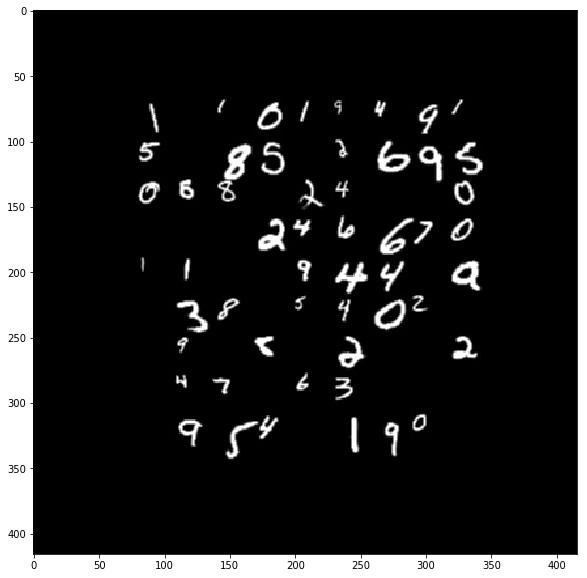

In [129]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(image_data[0])

In [130]:
return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: image_data})



In [131]:
pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)


In [132]:
pred_bbox = pred_bbox[pred_bbox[:,15]<0.1]

In [133]:
len(pred_bbox)

5463

In [134]:
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.05)
bboxes = utils.nms(bboxes, 0.5, method='nms')

In [135]:
len(bboxes)

54

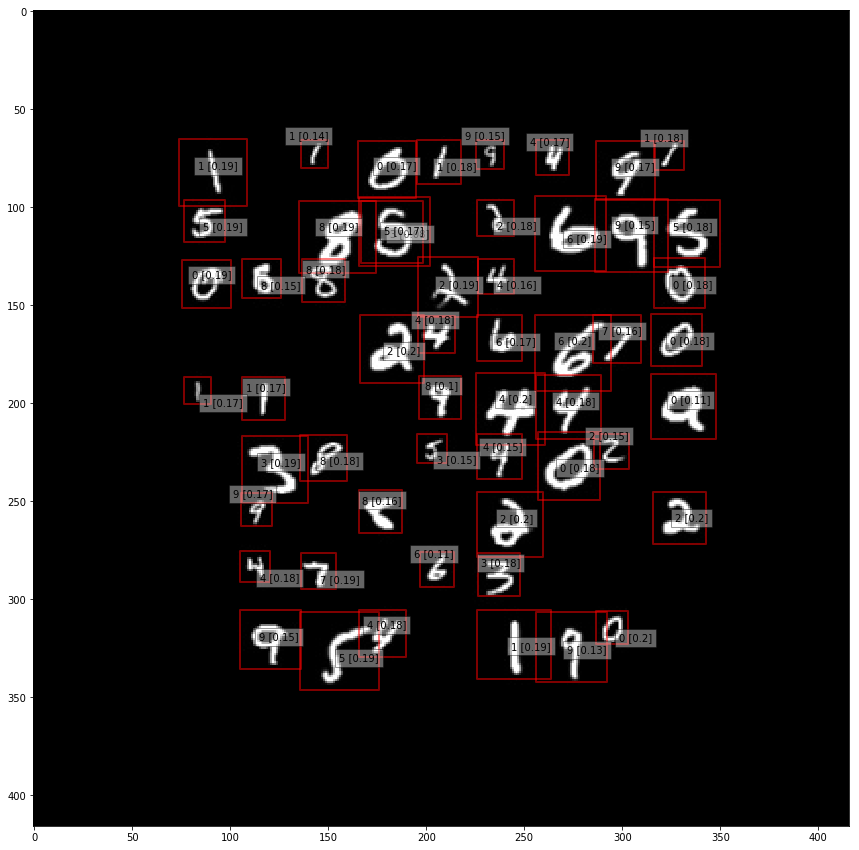

In [136]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(original_image)
rects = [ Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1]) for x in bboxes ]
ax = plt.gca()
pc = PatchCollection(rects, facecolor="None", alpha=0.5, linewidth=2,
                     edgecolor="red", )
ax.add_collection(pc)
for i, box in enumerate(bboxes):
    plt.text(box[0]+20 if i%2 == 0 else box[2]-10, box[1]+15 if i%2 == 0 else box[3]-15, 
             str(int(box[5])) + " [" + str(np.round(box[4],2)) + "]" , bbox=dict(facecolor='white', alpha=0.4), horizontalalignment="center" )

# Testing on an elections sheet real image

In [137]:
image_path      = "./demo/acta4.jpg"

In [138]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


In [139]:
input_image = original_image[0:1000,0:1000,:]
#input_image = 255 * np.ones(shape=[1000, 1000, 3], dtype=np.uint8)
#input_image[100:800, 300:650] = original_image[0:700,200:550,:]

In [140]:
input_image = cv2.blur(input_image, (5,5))

In [141]:
#original_image = cv2.blur(original_image,(5,5))

In [142]:
input_size      = 416

In [143]:
original_image_size = input_image.shape[:2]
image_data = utils.image_preporcess(np.copy(input_image), [input_size, input_size])
image_data = image_data
image_data = image_data[np.newaxis, ...]


In [144]:
#image_data = (1 - image_data)

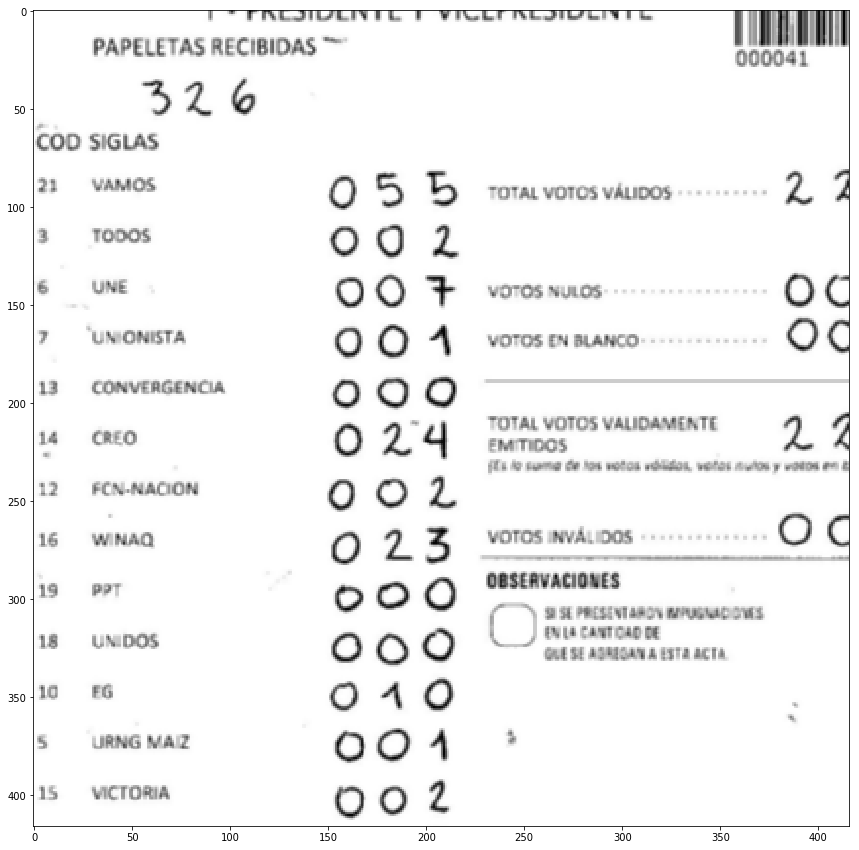

In [145]:
plt.imshow(image_data[0,:,:])

In [146]:
return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: 1-image_data})



In [147]:
pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)


In [148]:
# pred_bbox = pred_bbox[pred_bbox[:,15]<0.05]

In [149]:
pred_sbbox.shape

(1, 52, 52, 3, 16)

In [150]:
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.1)
bboxes = utils.nms(bboxes, 0.95, method='nms')

In [151]:
bboxes.__len__()

98

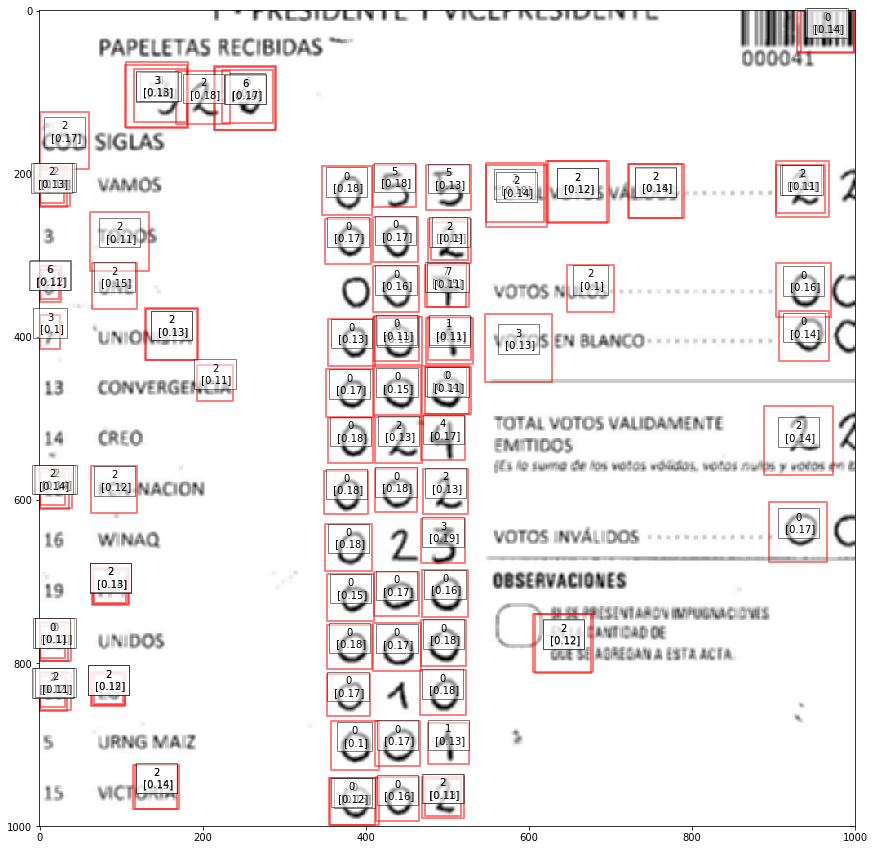

In [152]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(input_image)
rects = [ Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1]) for x in bboxes ]
ax = plt.gca()
pc = PatchCollection(rects, facecolor="None", alpha=0.5, linewidth=2,
                     edgecolor="red", )
ax.add_collection(pc)
for i, box in enumerate(bboxes):
    plt.text((box[0]+box[2])/2, (box[1]+box[3])/2, 
             str(int(box[5])) + "\n [" + str(np.round(box[4],2)) + "]" , bbox=dict(facecolor='white', alpha=0.5), horizontalalignment="center" )

In [38]:
len(pred_bbox)

10647

In [39]:
np.round(pred_bbox[0],3)

array([4.8780e+00, 4.3090e+00, 1.8905e+01, 1.8098e+01, 6.0000e-03,
       2.0000e-02, 6.4600e-01, 2.1000e-02, 3.9400e-01, 4.7000e-02,
       1.6100e-01, 1.5000e-02, 7.5000e-02, 3.0000e-02, 1.8000e-01,
       1.0000e-03], dtype=float32)